In [1]:
import numpy
import numpy as np
import tensorflow.keras as keras
import tensorflow as tf
from importlib import reload
import InputList
import BinaryReader
import Preprocessor
import models
import Callbacks

2022-02-11 21:32:02.740136: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-02-11 21:32:05.295179: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2022-02-11 21:32:05.295221: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2022-02-11 21:32:05.299248: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-02-11 21:32:05.410528: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1365] Profiler found 2 GPUs
2022-02-11 21:32:05.414947: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcupti.so.10.1
2022-02-11 21:32:05.417988: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2022-02-11 21:32:05.418162: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1487] CUPTI activity buffer flushed

In [15]:
reload(BinaryReader)

<module 'BinaryReader' from '/home/juliusmlcaesar/PycharmProjects/oct-classifier/BinaryReader.py'>

## Make this such that it can be used for prediction and training pipeline

In [16]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
reader = BinaryReader.BinaryReader()  # TODO: Normalizer
training_dataset, validation_dataset = reader.create_training_datasets(InputList.training_files)
preprocesser = Preprocessor.Preprocessor(training_dataset)

Num GPUs Available:  2
[('/mnt/p_Zeiss/Projects/UWF OCTA/Clinical data/MOON1/H3/raw_1536x2048x2045x2_9201.bin', 0), ('/mnt/p_Zeiss/Projects/UWF OCTA/Clinical data/MOON1/H6/rechts/raw_1536x2048x2045x2_8042.bin', 0), ('/mnt/p_Zeiss/Projects/UWF OCTA/Clinical data/MOON1/H3/raw_1536x2048x2045x2_9579.bin', 0), ('/mnt/p_Zeiss/Projects/UWF OCTA/Clinical data/MOON1/D78/links/raw_1536x2048x2045x2_18749.bin', 1)]


<PrefetchDataset shapes: ((1536, 23, 28, 1), ()), types: (tf.uint16, tf.uint8)>

In [7]:
print("Creating Normalization Layer:")
normalization_layer = preprocesser.normalize_layer()

Creating Normalization Layer:


2022-02-11 21:34:00.858518: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-02-11 21:34:00.881023: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2399655000 Hz


In [8]:
#normalization_weights = normalization_layer.get_weights()
#print("Before:" + str(normalization_weights))
normalization_weights_path = "results/normalization.npy"
#np.save(normalization_weights_path, normalization_weights)
normalization_layer.set_weights(np.load(normalization_weights_path))
print("After" + str(normalization_layer.get_weights()))

After[32762.3, 4103221.0, 9891840]


In [52]:
normalization_layer.set_weights(np.array([32743.002, 5470130.0, 25706913792]))

In [17]:
model = models.classiRaw3D(training_dataset.element_spec[0].shape, normalization_layer, reconstruction=False)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1536, 102, 102, 1 0         
_________________________________________________________________
normalization (Normalization (None, 1536, 102, 102, 1) 3         
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 1536, 102, 102, 64 1792      
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 768, 51, 51, 64)   0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 768, 51, 51, 128)  221312    
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 384, 25, 25, 128)  0         
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 384, 25, 25, 192)  6637

In [19]:
model.save('savedModels/second')

2022-02-14 09:07:19.282261: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: savedModels/second/assets


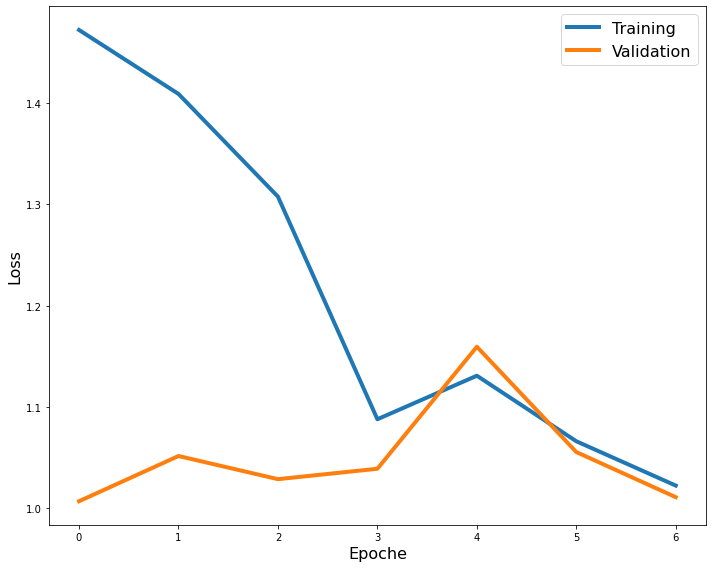

Epoch 8/30
    4/12800 [..............................] - ETA: 9:33:02 - loss: 1.0112 

2022-02-12 23:21:34.806809: W tensorflow/core/framework/op_kernel.cc:1751] Invalid argument: ValueError: could not broadcast input array from shape (0,) into shape (1536,)
Traceback (most recent call last):

  File "/home/juliusmlcaesar/miniconda3/envs/octClassifier/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 249, in __call__
    ret = func(*args)

  File "/home/juliusmlcaesar/miniconda3/envs/octClassifier/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 620, in wrapper
    return func(*args, **kwargs)

  File "/home/juliusmlcaesar/miniconda3/envs/octClassifier/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py", line 891, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/home/juliusmlcaesar/PycharmProjects/oct-classifier/BinaryReader.py", line 72, in instance_from_binaries_generator
    yield self._create_instance(f, instance_size), float(label)

  File "/home/juliusmlcaes

    6/12800 [..............................] - ETA: 10:07:36 - loss: 1.0111

InvalidArgumentError: 2 root error(s) found.
  (0) Invalid argument:  ValueError: could not broadcast input array from shape (0,) into shape (1536,)
Traceback (most recent call last):

  File "/home/juliusmlcaesar/miniconda3/envs/octClassifier/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 249, in __call__
    ret = func(*args)

  File "/home/juliusmlcaesar/miniconda3/envs/octClassifier/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 620, in wrapper
    return func(*args, **kwargs)

  File "/home/juliusmlcaesar/miniconda3/envs/octClassifier/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py", line 891, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/home/juliusmlcaesar/PycharmProjects/oct-classifier/BinaryReader.py", line 72, in instance_from_binaries_generator
    yield self._create_instance(f, instance_size), float(label)

  File "/home/juliusmlcaesar/PycharmProjects/oct-classifier/BinaryReader.py", line 124, in _create_instance
    instance[:, b_index, c_index, 0] = np.fromfile(file, dtype=self.data_type, count=instance_size.asize)

ValueError: could not broadcast input array from shape (0,) into shape (1536,)


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
  (1) Invalid argument:  ValueError: could not broadcast input array from shape (0,) into shape (1536,)
Traceback (most recent call last):

  File "/home/juliusmlcaesar/miniconda3/envs/octClassifier/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 249, in __call__
    ret = func(*args)

  File "/home/juliusmlcaesar/miniconda3/envs/octClassifier/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 620, in wrapper
    return func(*args, **kwargs)

  File "/home/juliusmlcaesar/miniconda3/envs/octClassifier/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py", line 891, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/home/juliusmlcaesar/PycharmProjects/oct-classifier/BinaryReader.py", line 72, in instance_from_binaries_generator
    yield self._create_instance(f, instance_size), float(label)

  File "/home/juliusmlcaesar/PycharmProjects/oct-classifier/BinaryReader.py", line 124, in _create_instance
    instance[:, b_index, c_index, 0] = np.fromfile(file, dtype=self.data_type, count=instance_size.asize)

ValueError: could not broadcast input array from shape (0,) into shape (1536,)


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
	 [[IteratorGetNext/_4]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_2246]

Function call stack:
train_function -> train_function


In [18]:
history = model.fit(
    preprocesser.batch(1),
    epochs=30,
    validation_data=Preprocessor.Preprocessor(validation_dataset).batch(1),
    callbacks=Callbacks.my_callbacks
)
model.save('savedModels/first')

In [69]:
reader.create_test_dataset([("/mnt/NewHDD/train_data/raw_1536x2048x2045x2_9201.bin", 0)])

In [3]:
new_model = tf.keras.models.load_model('savedModels/first')

2022-02-10 09:56:49.761062: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-02-10 09:56:49.761259: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-10 09:56:49.761278: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (zeissstudent1): /proc/driver/nvidia/version does not exist
2022-02-10 09:56:49.761470: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-10 09:56:49.761934: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set


In [82]:
test_dataset = reader.create_test_dataset([InputList.healthy_training_files[0]])
output_healthy = new_model.predict(test_dataset.batch(20))

In [74]:
test_dataset = reader.create_test_dataset([InputList.diabetic_training_files[4]])
output = new_model.predict(test_dataset.batch(20))

In [85]:
np.max(output_healthy)

-4.4209824

In [37]:
test_dataset = reader.create_test_dataset([InputList.healthy_training_files[4]])
output_healthy_val = new_model.predict(test_dataset.batch(20), callbacks=Callbacks.tboard_callback)

In [39]:
test_dataset = reader.create_test_dataset([("/mnt/NewHDD/train_data/raw_1536x2048x2045x2_9201.bin", 0)])
output_some_file = new_model.predict(test_dataset.batch(20), callbacks=Callbacks.tboard_callback)

KeyboardInterrupt: 

In [28]:
test_dataset = reader.create_test_dataset([InputList.healthy_testing_files[0]])
output_healthy_test = new_model.predict(test_dataset.batch(20))

In [6]:
test_dataset = reader.create_test_dataset([InputList.diabetic_testing_files[0]])
output_diabetic_test = new_model.predict(test_dataset.batch(20), callbacks=)

2022-02-10 09:57:10.869736: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-02-10 09:57:10.886408: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2899885000 Hz
2022-02-10 09:57:12.287878: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 5064622080 exceeds 10% of free system memory.
2022-02-10 09:57:17.295475: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 5064622080 exceeds 10% of free system memory.
2022-02-10 09:57:22.651924: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 5064622080 exceeds 10% of free system memory.
2022-02-10 09:57:28.308051: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 5064622080 exceeds 10% of free system memory.
2022-02-10 09:57:33.802789: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 5064622080 exceeds 10% of free system memory.


In [9]:
with open("instance_test/output_buffer.npy", "wb") as f:
    np.save(f, output_diabetic_test)

In [10]:
with open("instance_test/output_buffer.npy", "rb") as f:
    buffi = np.load(f)

In [11]:
buffi

array([[6.119612 ],
       [6.305094 ],
       [7.2212224],
       ...,
       [6.104448 ],
       [6.5245843],
       [6.7683864]], dtype=float32)

In [48]:
import Visualization
reload(Visualization)
testing_diabetic_image = Visualization.ImageVisualizer(output_diabetic_test,
                                                       info_map=None,
                                                       background_image_path=
                                                       "/mnt/p_Zeiss/Projects/UWF OCTA/Clinical data/MOON1/D71/rechts/retina_1536x2048x2045x2_2375.png")
testing_diabetic_image.plot_results_map("diabetic_test")

In [49]:
testing_healthy_image = Visualization.ImageVisualizer(output_healthy_test,
                                                       info_map=None,
                                                       background_image_path=
                                                       "/mnt/p_Zeiss/Projects/UWF OCTA/Clinical data/MOON1/D71/rechts/retina_1536x2048x2045x2_2375.png")
testing_healthy_image.plot_results_map("healthy_test")

In [ ]:
output_healthy_val

In [ ]:
i = 1

In [1]:
np.argmax(output_diabetic_test)

NameError: name 'np' is not defined

In [ ]:
reload(models)
model = models.classiRaw3D(training_dataset.element_spec[0].shape, normalization_layer, reconstruction=False)

In [224]:
training_dataset

<PrefetchDataset shapes: ((1536, 23, 28, 1), ()), types: (tf.uint16, tf.uint8)>

In [8]:
import tensorflow as tf
tf.debugging.set_log_device_placement(True)

Num GPUs Available:  0


In [18]:
model.load_weights("checkpoints/best_model")

In [12]:
with open("checkpoints/best_model.data-00000-of-00001") as testi:
    print(testi)

<_io.TextIOWrapper name='checkpoints/best_model.data-00000-of-00001' mode='r' encoding='UTF-8'>


print_function(Bag Number, dataset)

-> In einem Bag sind 7000 Instanzen

# Bag Level Model:

Ich hab ganz viele Softmaxes und von denen nehm ich einfach den Max Wert

In [68]:
test_dataset = reader.create_test_dataset([InputList.diabetic_training_files[4]])
output = model.predict(test_dataset.batch(20))

2022-02-08 18:00:53.002220: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 5064622080 exceeds 10% of free system memory.
2022-02-08 18:00:57.834422: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 5064622080 exceeds 10% of free system memory.
2022-02-08 18:01:03.134897: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 5064622080 exceeds 10% of free system memory.
2022-02-08 18:01:08.671641: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 5064622080 exceeds 10% of free system memory.
2022-02-08 18:01:14.168709: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 5064622080 exceeds 10% of free system memory.
